In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style="whitegrid")

## Forward Simulation

Parameters:

In [3]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [4]:
big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

array([[0.9, 0. , 0.1],
       [0. , 0.9, 0.1],
       [0.1, 0.1, 0.8]])

Simulation function

In [70]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(1+4*z) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]


## Visualizing

In [126]:
C, Z, X = sim(10,100)

In [127]:
color = {0:'red', 1:'green', 2: 'blue'}
C_color = [color[c] for c in C]
C_color

['blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red']

ValueError: ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green'] is not a valid value for color

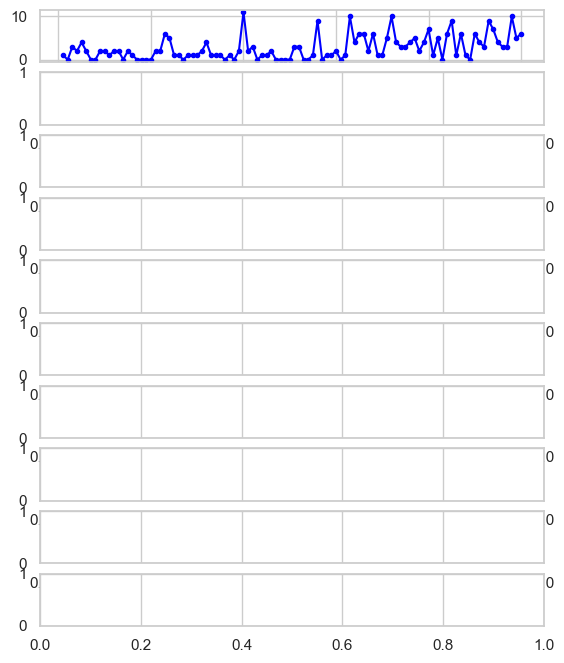

In [116]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[:, i] 
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='blue')
    y_plot_z = [Z[0][i]*10]
    for j in range(1,100):
        y_plot_z.append(Z[j][i]*10)
        
    axs[i].plot(x_plot, y_plot_z, marker='o', markersize=1, color = C_color)
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [14]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[:,i])



Text(0.5, 1.0, 'Average')

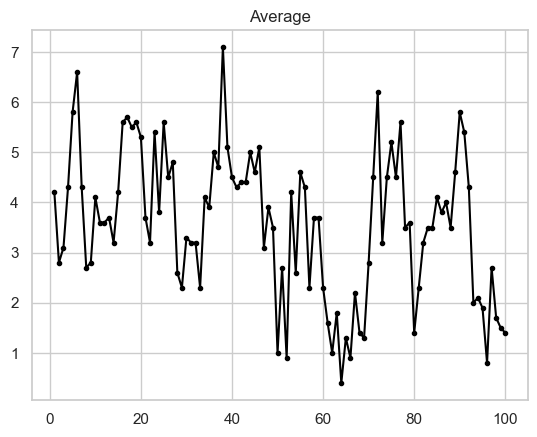

In [15]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')

## Multinomial logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [25]:
n1 = 100
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,n2, T)), np.empty(shape=(n1, n2, T))

for i in range(n1):
    C[i], Z[i], X[i] = sim(10,100)


In [28]:
X_reg = X.reshape((100, 100*10))

array([[5., 4., 8., ..., 5., 3., 2.],
       [0., 3., 1., ..., 5., 2., 0.],
       [7., 8., 0., ..., 3., 0., 0.],
       ...,
       [5., 5., 1., ..., 1., 1., 3.],
       [3., 2., 9., ..., 1., 2., 2.],
       [0., 0., 6., ..., 4., 1., 1.]])

In [31]:
lr = LogisticRegression()
lr.fit(X_reg, C[:,1])

LogisticRegression()

In [34]:
lr.coef_

array([[ 0.00433256, -0.01392313, -0.01452036, ...,  0.00817061,
         0.01302538,  0.00287775],
       [-0.01351331,  0.03555732,  0.02778372, ..., -0.00917063,
        -0.01426568,  0.00302111],
       [ 0.00918075, -0.02163418, -0.01326337, ...,  0.00100001,
         0.0012403 , -0.00589886]])

In [41]:
lr = LogisticRegression()
lr.fit(X_reg, C[:,2])
lr.coef_

array([[ 0.01125312, -0.02155563, -0.01528059, ...,  0.01593683,
         0.00104329,  0.00430311],
       [ 0.00036074,  0.01022524,  0.01839529, ..., -0.0056735 ,
        -0.02068812, -0.00798992],
       [-0.01161386,  0.01133038, -0.00311469, ..., -0.01026333,
         0.01964483,  0.00368681]])